In [3]:
# MATLAB code from https://github.com/briandaniel/KroghCylinderModel
# Brian Hong 6-19-19
# File determines the equations of the Krogh cylinder model of oxygen
# transport used in Mcguire, Secomb (2001)

# Adapted to Python by Emma Bluemke 2021

import numpy as np
from scipy.integrate import odeint

In [19]:
# param = value % Units | Description
Pb = 100; # Torr | Average partial pressure of oxygen in blood at capillary entrance 
P50 = 26; # Torr | Half-maximal hemoglobin saturation
n = 2.7; # - | Hill equation exponent
Cb = 0.2; # cm^3 O_2/cm^3 blood | Oxygen carrying capacity of blood
Sh = 2.5; # - | Sherwood number
Kpl = 8.3e-10; # (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Krogh diffusion constant in plasma

# prm.Vbar = 2.25; # mm/s | Average blood flow
Vbar = 2.25e-1; # cm/s | Average blood flow
# prm.Vbar = 3.49e-1; # cm/s | Average blood flow
K = 9.4e-10; # (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Krogh diffusion constant in tissue

# NOTE: In the text [M0] are is listed as cm^3 *100 cm^3/min, but should be
# listed as cm^3/(100 cm^3 * min )
# prm.M0 = 40; % cm^3 O_2 (100 cm^3*min) | Oxygen demand 
M0 = 40/6000; # cm^3 O_2 / ( cm^3*s ) | Oxygen demand

P0 = 1; # Torr | Half-maximal oxygen consumption
Dmb = 1.73e-7; # cm^2/s | Myoglobin diffusion coefficient
Cmb = 3.83e-7; # mol/cm^3 | Concentration of myoglobin
P50mb = 3.2; # Torr | Pressure where myoglobin 50% saturated with Oxygen

Vm = 2.24e4; # cm^3 | Molar volume
Mt = 6.52e-9;# (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Mass transfer coef

# From the text
#Rc = 2.5; # microns | Capillary radius
#L = 0.5; # mm | Capillary length
#Rt = 26; # microns | Tissue Cylinder radius

# Converted to consistent units
Rc = 2.5e-4; # cm | Capillary radius
L = 0.5e-1; # cm | Capillary length
Rt = 26e-4; # cm| Tissue Cylinder radius


# Numerical params
Nz = 50;
Nr = 100;


In [34]:
def guess(r):
    g =(1+r*0, 0*r);
    return(g)

def diffusionODE_BC(Ya,Yb,Pb,K,Rc):
    P_Rc = Ya[0]
    dPdr_Rc = Ya[1]
    
    dPdr_Rt = Yb[1]
    
    res1 = 2*pi*Rc*K*dPdr_Rc + Mt*(Pb-P_Rc)
    res2 = dPdr_Rt;
    
    res = (res1,res2)
    return(res)

def diffusionODE(r,Y,P0,M0,K):
    #NOTE: Y(1) = P, Y(2) = u, where u is the aux variable u = P'
    P = Y[1];
    u = Y[2];
    K = K; # Brian - why is this here?? Scared to remove - will it break things?
     
    # Oxygen consumption rate (per unit volume)
    MP = M0*(P/(P0+P));

    # In this case the derivatve is directly evaluated
    dudr = -u/r + 1/K*MP;
    dPdr = u;
    
    dY = (dPdr,dudr);
    return(dY)

In [35]:
z = np.linspace(0,L,Nz)
r_tissue = np.linspace(Rc,Rt,Nr)

Psltn = np.zeros((Nr,Nz))

for k in range(0,Nz):
    if k>0:
        # compute the integral
        MP = M0*(P/(P0 + P))
        q = 2*pi*trapz(r,MP*r)
        Shbi = (Pb/P50)^n/(1+(Pb/P50)^n)
        Ci = Cb*Shbi;
        dz = z(k)-z(k-1)
        volFlowRate = Vbar*pi*Rc^2
        Ciplus1 = Ci-dz*(q/volFlowRate)      
        Pb = P50*(Ciplus1/(Cb - Ciplus1))^(1/n)

    solinit = bvpinit(r_tissue, @guess ); ### need to replace
    #solinit = bvpinit(x,yinit) uses the initial mesh x and initial solution guess yinit 
    #to form an initial guess of the solution for a boundary value problem. You then can 
    #use the initial guess solinit as one of the inputs to bvp4c or bvp5c to solve the 
    #boundary value problem.
    
    # so I think I need https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html???

    odeFunc = @(r,Y) diffusionODE(r,Y,P0,M0,K); # ### need to replace - output is dY = (dPdr,dudr); 
    bcFunc = @(ya,yb) diffusionODE_BC(Ya,Yb,Pb,K,Rc); # ### need to replace - output is res = (res1,res2);

    sol = bvp4c(odeFunc, bcFunc, solinit ); ### need to replace
    #sol = bvp4c(odefun,bcfun,solinit) integrates a system of differential equations 
    #of the form y′ = f(x,y) specified by odefun, subject to the boundary conditions 
    #described by bcfun and the initial solution guess solinit. Use the bvpinit function 
    #to create the initial guess solinit, which also defines the points at which the 
    #boundary conditions in bcfun are enforced.

    P = interp1(sol.x,sol.y(0,:),r_tissue ); ### need to replace
    #vq = interp1(x,v,xq) returns interpolated values of a 1-D function at 
    #specific query points using linear interpolation. Vector x contains 
    #the sample points, and v contains the corresponding values, v(x). 
    #Vector xq contains the coordinates of the query points.
    r = r_tissue;

    Psltn[:,k] = P;

    print('Solving step k = ', str(k), '/', str(Nz))



SyntaxError: invalid syntax (<ipython-input-35-f99cbfba4b97>, line 18)

In [ ]:
figure('outerposition',[1000,500,500,500])

hold on
colors = parula(size(Psltn,2));
lin = plot(r*1e4,Psltn);
set(lin,{'color'},num2cell(colors,2))
xlabel('r [\mu m]')
ylabel('P [torr]')
set(gca,'xlim',[0,Rt*1e4])
set(gca,'ylim',[0,100])


figure('outerposition',[1498         458         984         751])
set(gcf, 'Renderer', 'opengl');
hold on
surf(z*1e1,r*1e4,Psltn,repmat(z*1e1,size(Psltn,1),1),'facealpha',1) # what is X,Y,Z here? X=z*1e1, Y=r*1e4, Z=Psltn?
view(130,30)
ylabel('r [\mu m]')
xlabel('z [mm]')
zlabel('P [torr]')


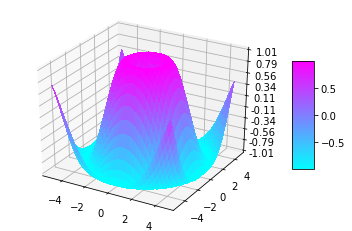

In [8]:
#surface plots in python:

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.cool,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()